In [2]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import stim
import scienceplots
plt.style.use('science')
plt.rcParams['figure.dpi'] = 300
import matplotlib.colors as colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[colors.hex2color("#66c2a5"), colors.hex2color("#fc8d62"), colors.hex2color("#8da0cb"), colors.hex2color("#e78ac3"), colors.hex2color( "#a6d854")])
import pymatching
import networkx as nx
import itertools
%matplotlib ipympl

from src.rotated_surface_code import RotatedCode
from src.graph_representation import get_syndrome_graph, get_node_feature_matrix, get_edges
from src.mwpm_prediction import compute_mwpm_reward
from src.gnn_model import EdgeWeightGNN, sample_weights_get_log_probs

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data
from qecsim.graphtools import mwpm
import os
import re
from torch_geometric.nn import summary

# Results code capacity 

0.001
0.001
0.001
0.001
0.001
0.001


Text(0, 0.5, 'Accuracy')

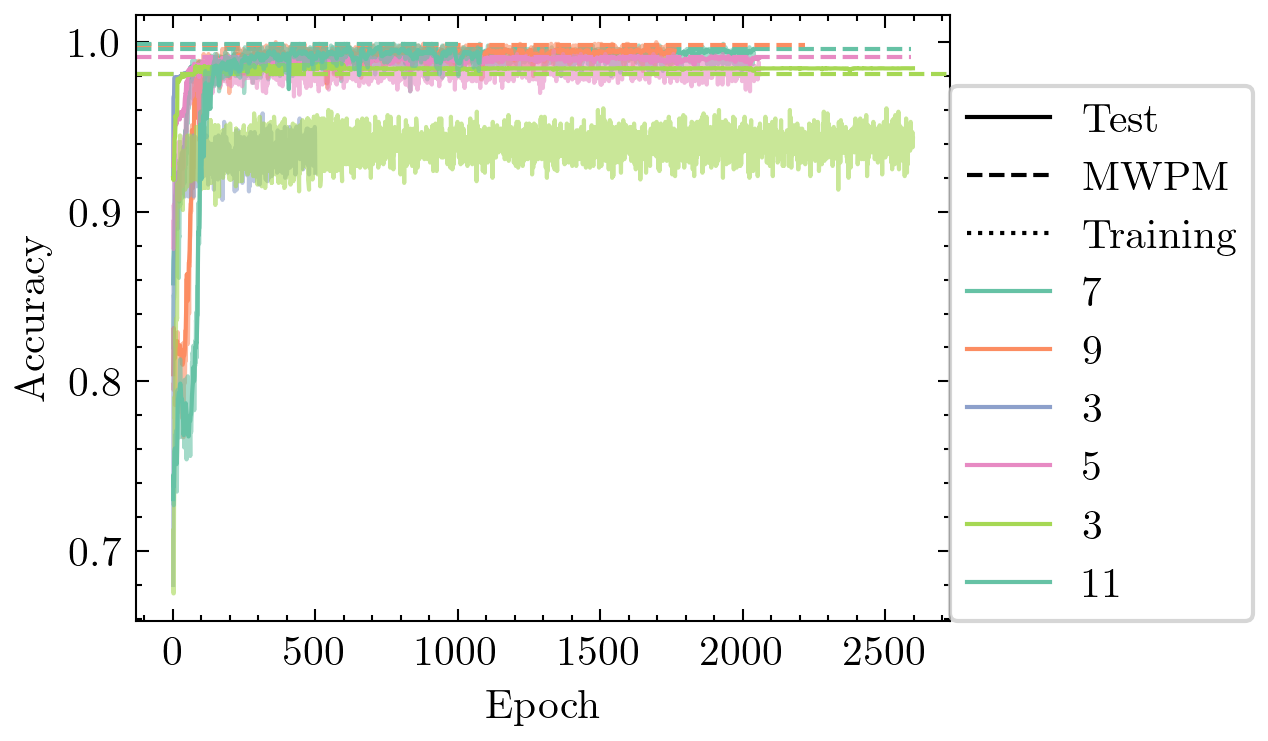

In [18]:
mwpm = np.genfromtxt('MWPM_2D_3_11.csv', delimiter=',')
fig, ax = plt.subplots()
parent = 'saved_models/gcn_32_64_mlp_128_64_32/'
all_files = os.listdir(parent)
ax.plot(6, 0.9, c = 'black', ls = 'solid', label = 'Test')
ax.plot(6, 0.9, c = 'black', ls = 'dashed', label = 'MWPM')
ax.plot(6, 0.9, c = 'black', ls = 'dotted', label = 'Training')

# all_files = ['d_5_p_0p1_test']
for i, file_name in enumerate(all_files):
    
    file_folder = parent + file_name
    # Use regex to extract the integer after 'd_'
    match = re.search(r'd_(\d+)_p', file_name)
    if match:
        d = int(match.group(1))  # Convert extracted string to integer
    match = re.search(r'e_(\d+).pt', file_name)
    if match:
        lr = int(match.group(1))  # Convert extracted string to integer
    d_check = mwpm[:, 0] == d
    p_check = np.isclose(mwpm[0, :], 0.05)
    mwpm_acc = 1 - mwpm[d_check, p_check]
    model = torch.load(file_folder, map_location = torch.device('cpu'), weights_only=False)
    history = model['history']
    # Extract epochs and loss values
    epochs = [entry['epoch'] for entry in history]
    reward = [entry['epoch_reward'] for entry in history]
    train_acc = [entry['train_acc'] for entry in history]
    test_acc = [entry['test_acc'] for entry in history]
    # ax[0].plot(epochs, reward, label = f'd = {d}')
    optimizer_state = model['optimizer_state_dict']
    for param_group in optimizer_state['param_groups']:
        print(param_group['lr'])

    ax.plot(epochs, train_acc, alpha = 0.6)
    ax.plot(epochs, test_acc, c = plt.gca().lines[-1].get_color(), label = f'{d}')
    ax.axhline(mwpm_acc, 0, len(epochs) / ax.get_xlim()[1], c = plt.gca().lines[-1].get_color(), ls = 'dashed')
ax.legend(frameon = True, loc = (1, 0))
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
# plt.tight_layout()

In [ ]:
history

# MWPM baseline

In [ ]:
def num_decoding_failures(code, p, num_trials):
    num_errors = 0
    for i in range(num_trials):
        error = code.generate_error_chain(p)
        eq_class = code.get_eq_class(error)
        y = eq_class[1] # the parity of Z errors on the western edge
        correction = code.get_MWPM_correction(error)
        y_MWPM = code.get_eq_class(correction)[1]

        if not np.array_equal(y, y_MWPM):           # count error if eq. classes differ
            num_errors += 1
    return num_errors

In [ ]:
Ls = [11]                # code distances
num_code_distances = len(Ls)
rates = np.arange(0.01, 0.21, 0.01)     # physical error rates
num_error_rates = len(rates)

result_matrix = np.zeros((num_code_distances + 1, num_error_rates + 1))
result_matrix[0, 1:] = rates                                    # first row: physical error rates
result_matrix[1:, 0] = Ls                                       # first column: code distances

num_trials = 100_000

for i in range(num_code_distances):
    print(f'Calculating for L = {Ls[i]}')
    code = RotatedCode(Ls[i])
    code.init_matching()
    log_errors = []
    for p in rates:
        num_errors = num_decoding_failures(code, p, num_trials)
        log_errors.append(num_errors / num_trials)
    result_matrix[i + 1, 1:] = log_errors                           # logical errors in row corresponding to grid_size 

# np.savetxt("MWPM_2D_11.csv", result_matrix, delimiter=",")

Text(0, 0.5, 'Logical failure rate of $Z_L$')

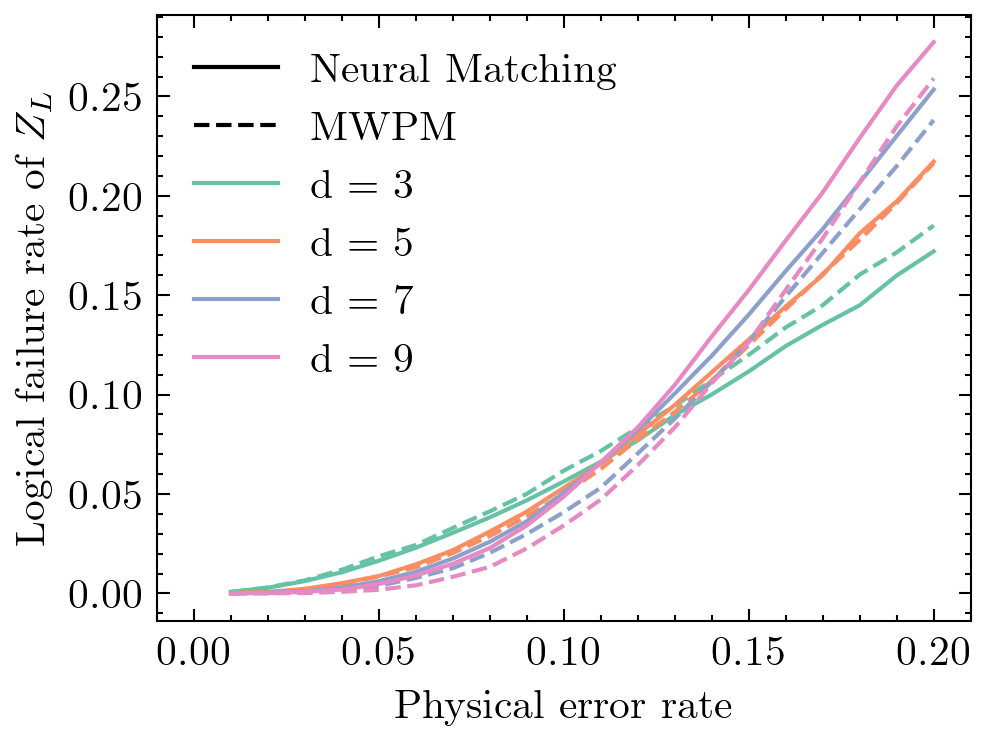

In [59]:
fig, ax = plt.subplots()
rates = np.arange(0.01, 0.21, 0.01)     # physical error rates
ax.plot(0, 0, c = 'black', ls = 'solid', label = 'Neural Matching')
ax.plot(0, 0, c = 'black', ls = 'dashed', label = 'MWPM')
ds = [3, 5, 7, 9]
for d in ds:
    name = ("d_" + str(d))
    accuracy_file = 'accuracies/gcn_4_64_64_mlp_129_256_64_sigmoid/' + name + '_accuracy.csv'
    gnn_acc = np.genfromtxt(accuracy_file, delimiter=',')
    ax.plot(rates, 1 - gnn_acc, label = f'd = {d}')

    d_check = mwpm[:, 0] == d
    mwpm_acc = mwpm[d_check, 1:].flatten()
    ax.plot(rates, mwpm_acc, c = plt.gca().lines[-1].get_color(), ls = 'dashed')
ax.legend()
ax.set_xlabel('Physical error rate')
ax.set_ylabel(r'Logical failure rate of $Z_L$')

In [ ]:
result_matrix[d_check, p_check]

In [ ]:
p = 0.1
d = 5
code = RotatedCode(d)

In [ ]:
test_set_size = 10000

In [ ]:
test_set = []
test_n_trivials = 0
I = 0
Z = 0
for _ in range(test_set_size):
    graph = get_syndrome_graph(code, p)
    if not graph == None:
       test_set.append(graph)
       if graph.y == 0:
           I += 1
       else:
           Z += 1
    else: 
        test_n_trivials += 1
    
n_nontrivial_test_samples = len(test_set)
n_trivial_test_samples = test_set_size - n_nontrivial_test_samples

In [ ]:
n_nontrivial_test_samples

In [ ]:
I

In [ ]:
random_correct = n_nontrivial_test_samples / 2

In [ ]:
(random_correct + n_trivial_test_samples) / test_set_size

We check for Z_L, so we count the parity of Z on the western edge, (second entry in logical class [X_L, Z_L]), remove all nodes that are not X ([1, 0], orange plaquette) stabilizers and count the parity of edges along the western edge of the matching of the X ([1, 0]) stabizers. 

In [30]:
d = 5
code = RotatedCode(d)
p = 0.05

In [31]:
code.size

5

In [9]:
model = EdgeWeightGNN()

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Calculate number of trainable parameters
num_params = count_parameters(model)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 31457


In [44]:
name = ("d_" + str(d) + "_p_" + "0p5_sigmoid_lr_1e_4")
# current_datetime = datetime.now().strftime("%y%m%d-%H%M%S")
# name = name + current_datetime
checkpoint_path = 'saved_models/gcn_4_64_64_mlp_129_256_64_sigmoid/' + name + '.pt'
start_epoch = 0
try:
    checkpoint = torch.load(checkpoint_path, weights_only=True)
    start_epoch = checkpoint['epoch']  # Get the epoch from checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])  # Load model weights
    print(f"Checkpoint loaded, continuing from epoch {start_epoch}.")
except FileNotFoundError:
    print("No checkpoint found, starting from scratch.")

Checkpoint loaded, continuing from epoch 1510.


In [19]:
model = EdgeWeightGNN()

In [29]:
def get_syndrome_graph(code, p, ax):
    error = code.generate_error_chain(p)
    eq_class = code.get_eq_class(error)
    y = torch.tensor(0, dtype=torch.float32) # the parity of Z errors on the western edge
    syndrome = code.get_syndrome(error)
    # syndrome = np.array([[0, 0, 0, 0, 0, 0],
    #                      [0, 0, 0, 0, 0, 0],
    #                      [0, 0, 1, 0, 1, 0],
    #                      [0, 0, 0, 0, 0, 0],
    #                      [0, 0, 0, 0, 0, 0],
    #                      [0, 0, 0, 0, 0, 0]])
    # code.plot_syndrome(syndrome=syndrome, ax=ax)
    # check number of X stabilizers:
    if np.sum(syndrome == 1) == 0:
        return None
    else:
        node_features = get_node_feature_matrix(syndrome)
        edge_index, edge_attr = get_edges(node_features)
        graph = Data(x = node_features, edge_index = edge_index, edge_attr = edge_attr, y = y)
    
        return graph
# fig, ax = plt.subplots()
data = get_syndrome_graph(code, p, ax)
with torch.no_grad():
    edge_index, edge_weights_mean, num_real_nodes, num_boundary_nodes = \
                model(data.x, data.edge_index, data.edge_attr)
    summary(model, data.x, data.edge_index, data.edge_attr)
    print(edge_index)
    print(edge_weights_mean)
    print(edge_weights_mean[1] / edge_weights_mean[0])
    print(compute_mwpm_reward(edge_index, edge_weights_mean, num_real_nodes,num_boundary_nodes, data.y))
    sampled_edge_weights, log_probs = sample_weights_get_log_probs(edge_weights_mean, 100, 0.1)
    print(torch.min(sampled_edge_weights))

ModuleNotFoundError: No module named 'tabulate'

In [ ]:
model = EdgeWeightGNN()
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000
loss_history, mean_history = [], []
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_reward = 0
    optimizer.zero_grad()
    for i in range(num_samples):  # Draw multiple samples per epoch
        data = graph_list[i]
        all_log_probs = []
        all_rewards = []
        # Forward pass: Get sampled edge weights and their log-probabilities
        edge_index, edge_weights_mean, num_real_nodes, num_boundary_nodes = \
            model(data.x, data.edge_index, data.edge_attr)
        prediction, matching = compute_mwpm_reward(edge_index, edge_weights_mean, num_real_nodes,num_boundary_nodes, data.y)
        sampled_edge_weights, log_probs = sample_weights_get_log_probs(edge_weights_mean, num_draws_per_sample, stddev)
        # sampled_edge_weights = torch.sigmoid(sampled_edge_weights)
        for j in range(num_draws_per_sample):
            edge_weights_j = sampled_edge_weights[j, :]
            reward = compute_mwpm_reward(edge_index, edge_weights_j, num_real_nodes,num_boundary_nodes, data.y)
            # Store log-probabilities and rewards
            all_log_probs.append(log_probs[j])
            all_rewards.append(reward)
        # Stack log-probs and rewards for averaging
        all_log_probs = torch.stack(all_log_probs)  # Shape: (num_draws_per_sample,)
        all_rewards = torch.tensor(all_rewards, dtype=torch.float32)            # Shape: (num_draws_per_sample,)
        # The loss per draw and per edge is the log-probability times the reward
        loss_per_draw = all_log_probs * all_rewards  # Shape: (num_draws_per_sample, )

        # Compute the REINFORCE loss for each edge
        loss_per_sample = -torch.mean(loss_per_draw)  # Shape: (1,)
        mean_reward_per_sample = torch.mean(all_rewards)
        loss_per_sample.backward()  # Accumulate gradients
        epoch_loss += loss_per_sample.item()
        epoch_reward += mean_reward_per_sample.item()

    optimizer.step()  # Perform a single optimization step after accumulating gradients
    epoch_loss /= num_samples
    epoch_reward /= num_samples
    loss_history.append(epoch_loss)
    mean_history.append(edge_weights_mean.detach().numpy())
    # Print training progress
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.4f}, Mean Reward: {epoch_reward:.4f}')
loss_history = np.array(loss_history)
mean_history = np.array(mean_history)

In [ ]:
epoch = np.arange(num_epochs)
fig, ax = plt.subplots()
mean_history_derivative = np.diff(mean_history, axis=0)
mean_history_derivative_sign = np.sign(mean_history_derivative)
epoch_derivative = epoch[:-1]

# for i in range(mean_history_derivative.shape[1]):
#     ax.plot(epoch_derivative, mean_history_derivative_sign[:, i], alpha = 0.7, label=f'Edge {i}')

# mean_history_derivative_sign_diff = mean_history_derivative_sign[:, 0] - mean_history_derivative_sign[:, 1]
# ax.plot(epoch_derivative, mean_history_derivative_sign_diff, label = 'Left - Right')

for i in range(mean_history.shape[1]):
    ax.plot(epoch, mean_history[:, i], label = f'Edge {i}')

ax.legend(loc = 'upper right')

# events = [1800, 2900, 4400]
# for e in events:
#     ax.axvline(e, color = 'red', linestyle = '--')


In [ ]:
np.sum(mean_history_derivative_sign_diff == 0)

In [ ]:
np.sum(mean_history_derivative_sign_diff != 0)  